In [1]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise,
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):

    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))

    return (w[:d], w[d])

In [4]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [5]:
# Sub-Problem 1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    n, d = X.shape

    # Initialize w and w0 using Initialw function
    w, w0 = Initialw(X, y)

    # Keep track of objective function values
    obj_values = []

    # Previous w for convergence check
    w_prev = np.copy(w)

    # Define the soft-thresholding function
    def soft_thresholding(a, b):
        return np.sign(a) * np.maximum(np.abs(a) - b, 0.0)

    for iteration in range(max_iter):
        # For each coordinate
        for j in range(d):
            # Compute residual without x_j w_j
            r = y - (X @ w + w0) + X[:, j] * w[j]

            # Compute rho
            rho = X[:, j].T @ r

            # Compute z_j
            z_j = np.sum(X[:, j] ** 2)

            # Update w_j using soft-thresholding
            w_j_new = soft_thresholding(rho / z_j, lmda / z_j)

            # Update w_j
            w[j] = w_j_new

        # Update w0
        w0 = np.mean(y - X @ w)

        # Compute objective function value
        obj = 0.5 * np.sum((y - X @ w - w0) ** 2) + lmda * np.sum(np.abs(w))
        obj_values.append(obj)

        # Check convergence
        max_w_change = np.max(np.abs(w - w_prev))
        if max_w_change <= epsilon:
            #print(f"Converged at iteration {iteration+1}")
            break

        w_prev = np.copy(w)

    if draw_curve:
      plt.plot(obj_values)
      plt.xlabel('Iteration')
      plt.ylabel('Objective Function Value')
      plt.title('Objective Function vs. Iteration')
      plt.show()

    return (w,w0)

In [6]:
# Sub-Problem 1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

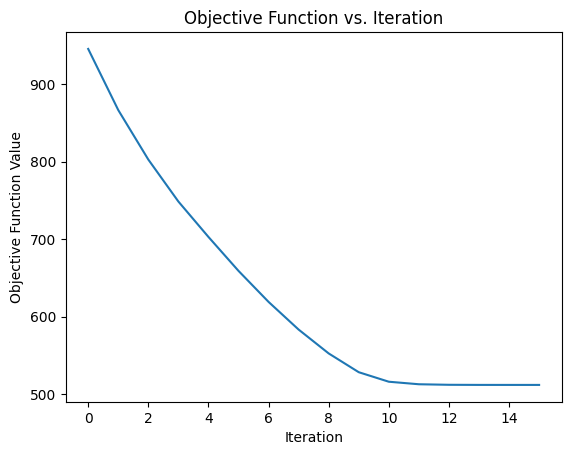

Estimated w: [ 9.79800275e+00 -9.68563053e+00 -9.69063070e+00  9.82989921e+00
  9.94349829e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.18879339e-02
  1.52358400e-01  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -4.40473500e-02  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.26609958e-02 -0.00000000e+00
 -7.13624975e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.90777951e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000

In [7]:
# Sub-Problem 1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print("Estimated w:", w_lasso)
print("Estimated w0:", w0_lasso)
print("indices of non-zero weight entries:", np.nonzero(w_lasso)[0])
print(w_lasso)

In [8]:
# Sub-Problem 2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    # Compute predictions
    y_pred = X @ w + w0

    # Compute RMSE
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))

    # Compute sparsity of w (number of non-zero entries)
    sparsity_w = np.count_nonzero(w)

    # Find non-zero indices in w (predicted positives)
    predicted_positives = set(np.nonzero(w)[0])

    # Find non-zero indices in w_true (actual positives)
    actual_positives = set(np.nonzero(w_true)[0])

    # Compute true positives (intersection)
    true_positives = predicted_positives & actual_positives

    # Number of predicted positives
    n_predicted_positives = len(predicted_positives)

    # Number of actual positives
    n_actual_positives = len(actual_positives)

    # Number of true positives
    n_true_positives = len(true_positives)

    # Precision: TP / (TP + FP)
    if n_predicted_positives > 0:
        precision_w = n_true_positives / n_predicted_positives
    else:
        precision_w = 0.0

    # Recall: TP / (TP + FN)
    if n_actual_positives > 0:
        recall_w = n_true_positives / n_actual_positives
    else:
        recall_w = 0.0

    return (rmse, sparsity_w, precision_w, recall_w)

In [9]:
# Sub-Problem 2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)

# Print the evaluation metrics
rmse, sparsity_w, precision_w, recall_w = Emetric
print(f"RMSE: {rmse}")
print(f"Sparsity of w: {sparsity_w}")
print(f"Precision of w: {precision_w}")
print(f"Recall of w: {recall_w}")

RMSE: 0.8264628606246416
Sparsity of w: 13
Precision of w: 0.38461538461538464
Recall of w: 1.0


In [10]:
# Sub-Problem 3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########
    n, d = X.shape

    # Compute λ_max = max_j |X_j^T (y - ȳ)|
    y_mean = np.mean(y)
    y_centered = y - y_mean
    Xy = X.T @ y_centered
    lambda_max = np.max(np.abs(Xy))

    # Generate 50 λ values from λ_max to λ_min = 0)
    Lmda = np.linspace(lambda_max, 0, 50)

    # Initialize lists to store weights and intercepts
    W = []
    W0 = []

    # For warm start (initialize w and w0 from previous solution)
    w_init, w0_init = Initialw(X, y)

    for lmda in Lmda:
        # Run lasso with warm start
        w_lasso, w0_lasso = lasso(X, y, lmda=lmda, epsilon=1.0e-2, draw_curve=False, max_iter=100)

        # Store weights and intercept
        W.append(w_lasso)
        W0.append(w0_lasso)

        # Update initial weights for warm start (optional)
        w_init, w0_init = w_lasso, w0_lasso

    # Convert W and W0 to numpy arrays
    W = np.array(W).T  # Now W is d x 50
    W0 = np.array(W0)

    return (W, W0, Lmda)

In [11]:
# Sub-Problem 3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########
    # Number of solutions
    num_solutions = W.shape[1]

    # Initialize lists
    RMSE = []
    Sparsity = []
    Precision = []
    Recall = []

    # Non-zero indices in w_true
    actual_positives = set(np.nonzero(w_true)[0])

    for i in range(num_solutions):
        w = W[:, i]
        w0 = W0[i]

        # Compute RMSE
        y_pred = X @ w + w0
        rmse = np.sqrt(np.mean((y - y_pred) ** 2))
        RMSE.append(rmse)

        # Compute sparsity
        sparsity_w = np.count_nonzero(w)
        Sparsity.append(sparsity_w)

        # Find non-zero indices in w (predicted positives)
        predicted_positives = set(np.nonzero(w)[0])

        # Compute true positives (intersection)
        true_positives = predicted_positives & actual_positives

        # Number of predicted positives
        n_predicted_positives = len(predicted_positives)

        # Number of actual positives
        n_actual_positives = len(actual_positives)

        # Number of true positives
        n_true_positives = len(true_positives)

        # Precision
        if n_predicted_positives > 0:
            precision_w = n_true_positives / n_predicted_positives
        else:
            precision_w = 0.0
        Precision.append(precision_w)

        # Recall
        if n_actual_positives > 0:
            recall_w = n_true_positives / n_actual_positives
        else:
            recall_w = 0.0
        Recall.append(recall_w)

    return (RMSE, Sparsity, Precision, Recall)

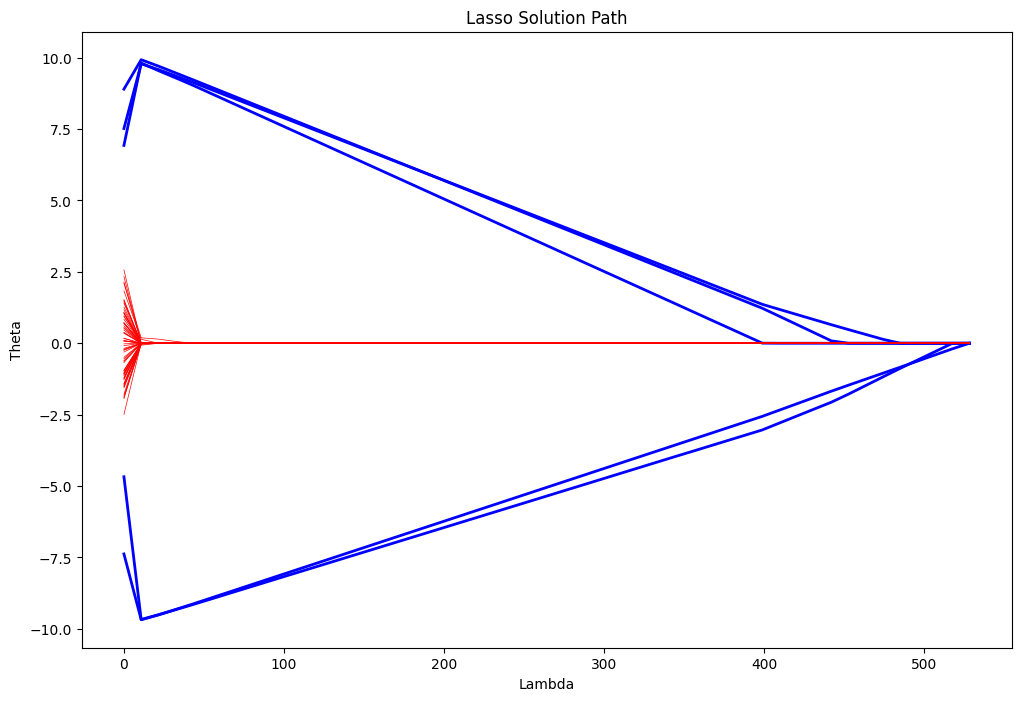

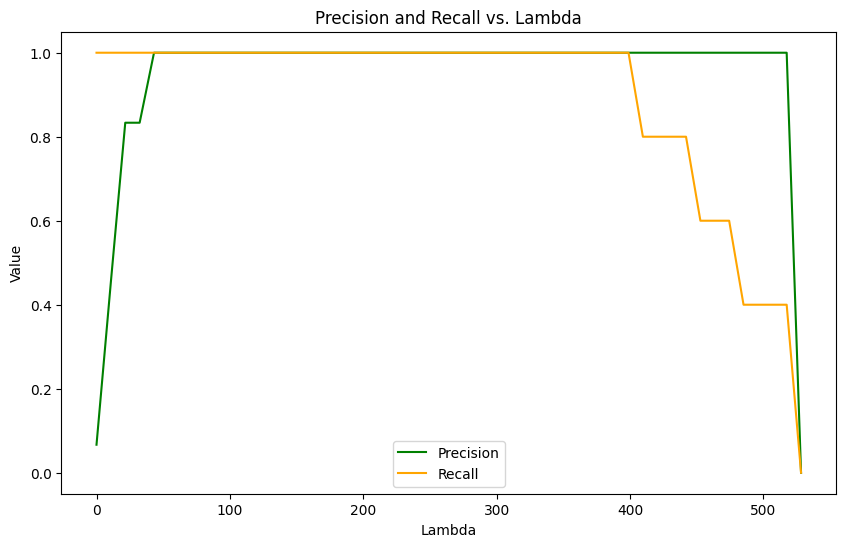

In [12]:
# Sub-Problem 3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)

# Compute the Lasso solution path
W, W0, Lmda = LassoPath(X, y)

# Evaluate the Lasso solution path
RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

# Plot the Lasso solution paths
plt.figure(figsize=(12, 8))

# Indices of the true features
true_indices = set(np.nonzero(w_true)[0])

# Plot θi vs λ for each θi
for i in range(W.shape[0]):
    if i in true_indices:
        plt.plot(Lmda, W[i, :], color='blue', linewidth=2)
    else:
        plt.plot(Lmda, W[i, :], color='red', linewidth=0.5)

plt.xlabel('Lambda')
plt.ylabel('Theta')
plt.title('Lasso Solution Path')
plt.show()

# Plot precision and recall vs. lambda
plt.figure(figsize=(10, 6))
plt.plot(Lmda, Precision, label='Precision', color='green')
plt.plot(Lmda, Recall, label='Recall', color='orange')
plt.xlabel('Lambda')
plt.ylabel('Value')
plt.title('Precision and Recall vs. Lambda')
plt.legend()
plt.show()

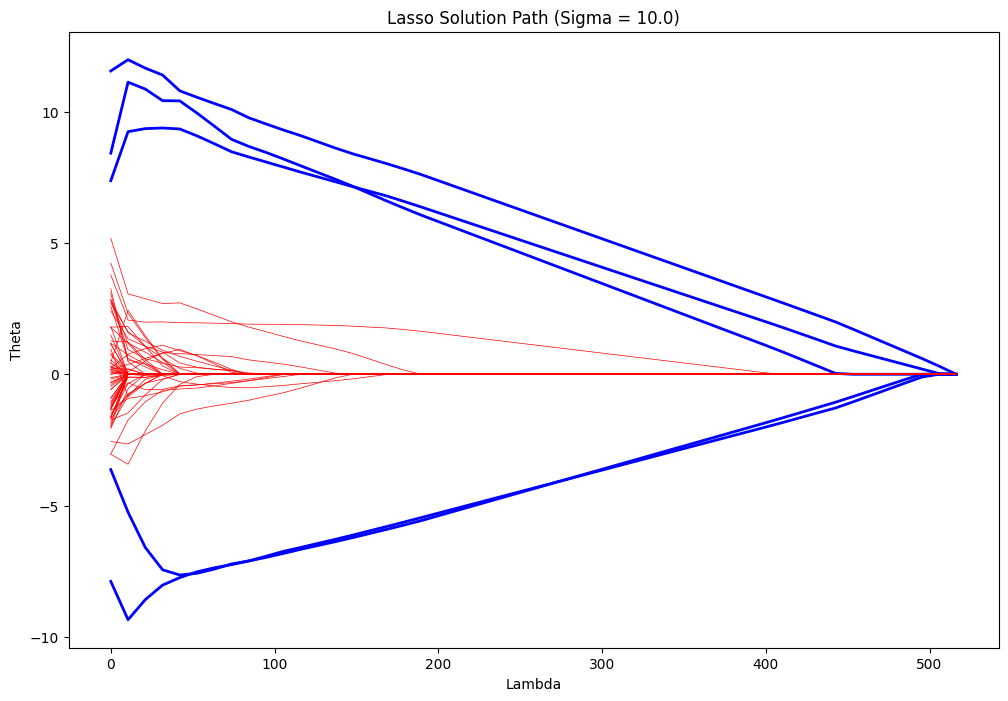

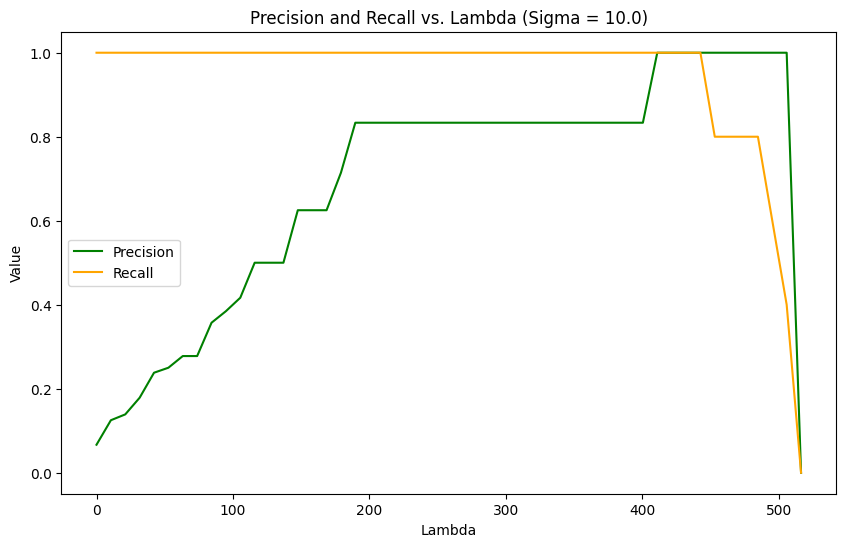

In [13]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
# Compute the Lasso solution path for the new data
W, W0, Lmda = LassoPath(X, y)

# Evaluate the Lasso solution path
RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

# Plot the Lasso solution paths for sigma = 10.0
plt.figure(figsize=(12, 8))

# Plot θi vs λ for each θi
for i in range(W.shape[0]):
    if i in true_indices:
        plt.plot(Lmda, W[i, :], color='blue', linewidth=2)
    else:
        plt.plot(Lmda, W[i, :], color='red', linewidth=0.5)

plt.xlabel('Lambda')
plt.ylabel('Theta')
plt.title('Lasso Solution Path (Sigma = 10.0)')
plt.show()

# Plot precision and recall vs. lambda for sigma = 10.0
plt.figure(figsize=(10, 6))
plt.plot(Lmda, Precision, label='Precision', color='green')
plt.plot(Lmda, Recall, label='Recall', color='orange')
plt.xlabel('Lambda')
plt.ylabel('Value')
plt.title('Precision and Recall vs. Lambda (Sigma = 10.0)')
plt.legend()
plt.show()

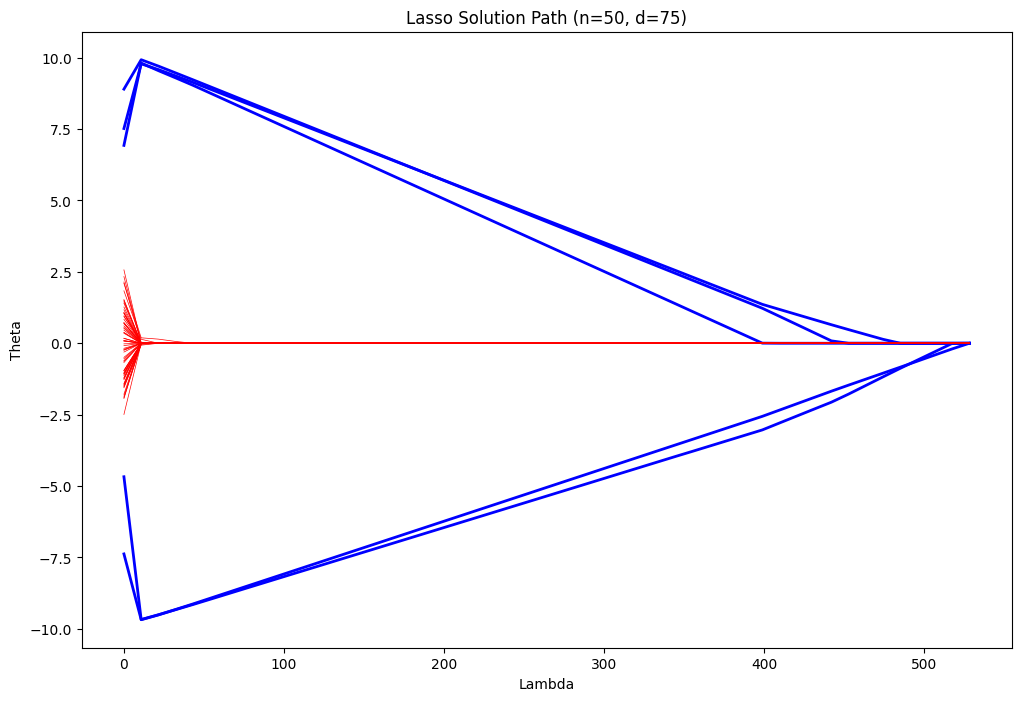

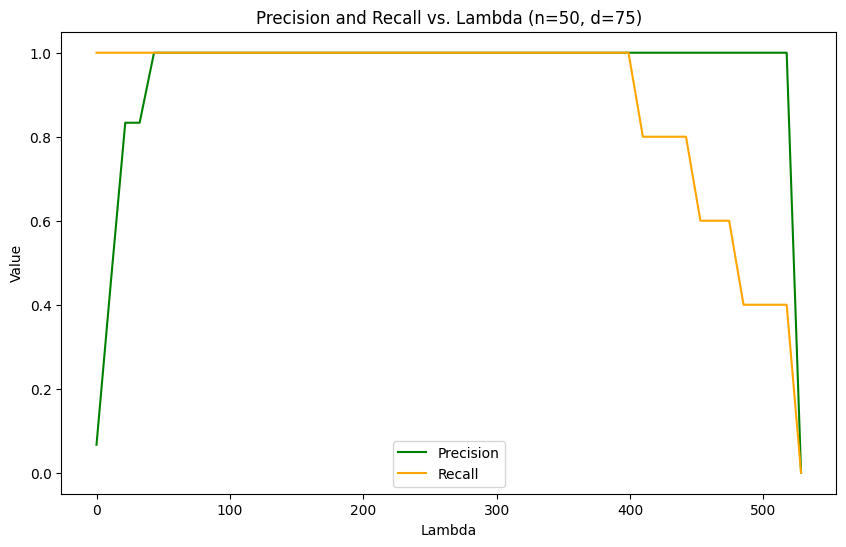

First Lambda=398.8879 gives good precision and recall
Last Lambda=43.1230 gives good precision and recall


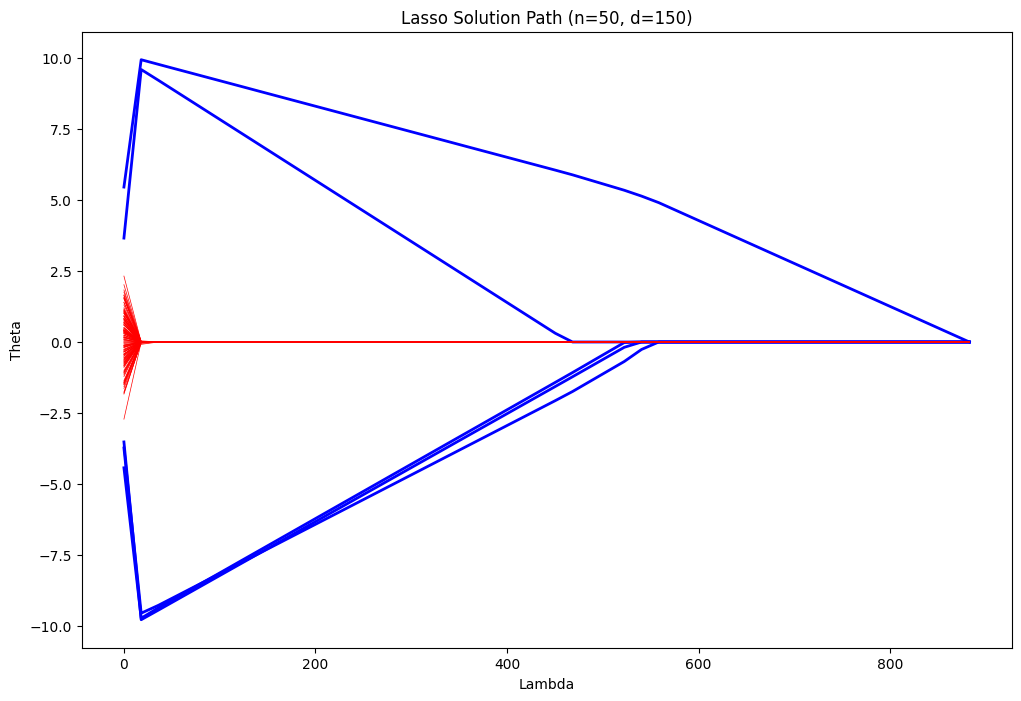

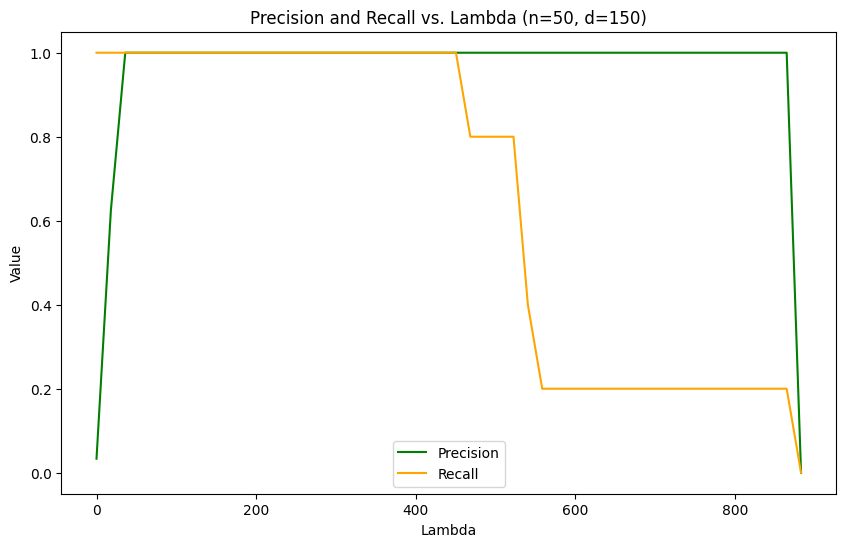

First Lambda=450.3937 gives good precision and recall
Last Lambda=36.0315 gives good precision and recall


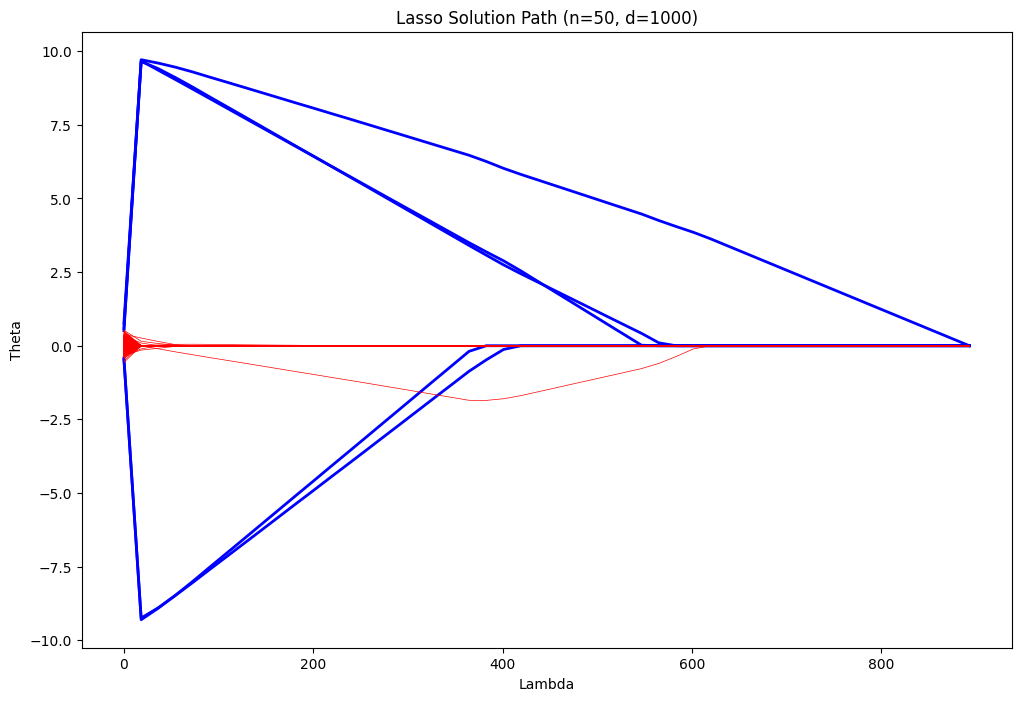

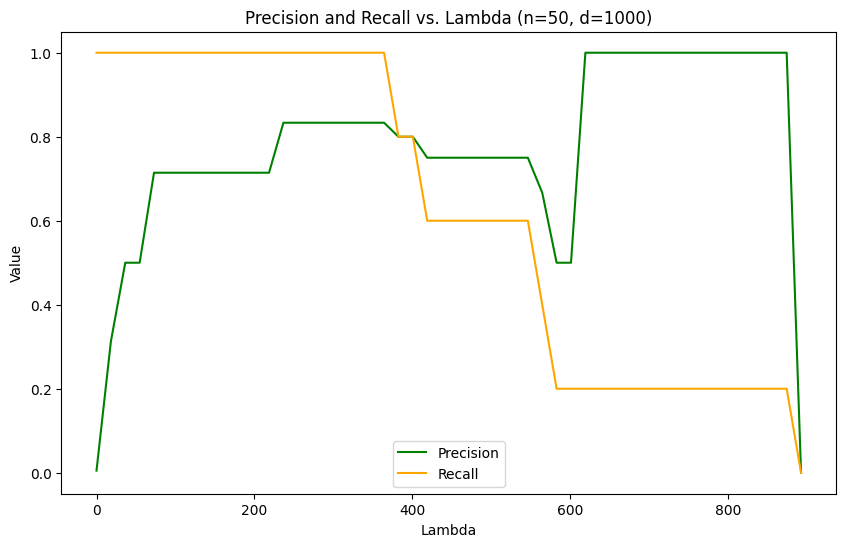

Could not find any lambda that gives both good precision and recall


<ipython-input-3-547bc05f37a0>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


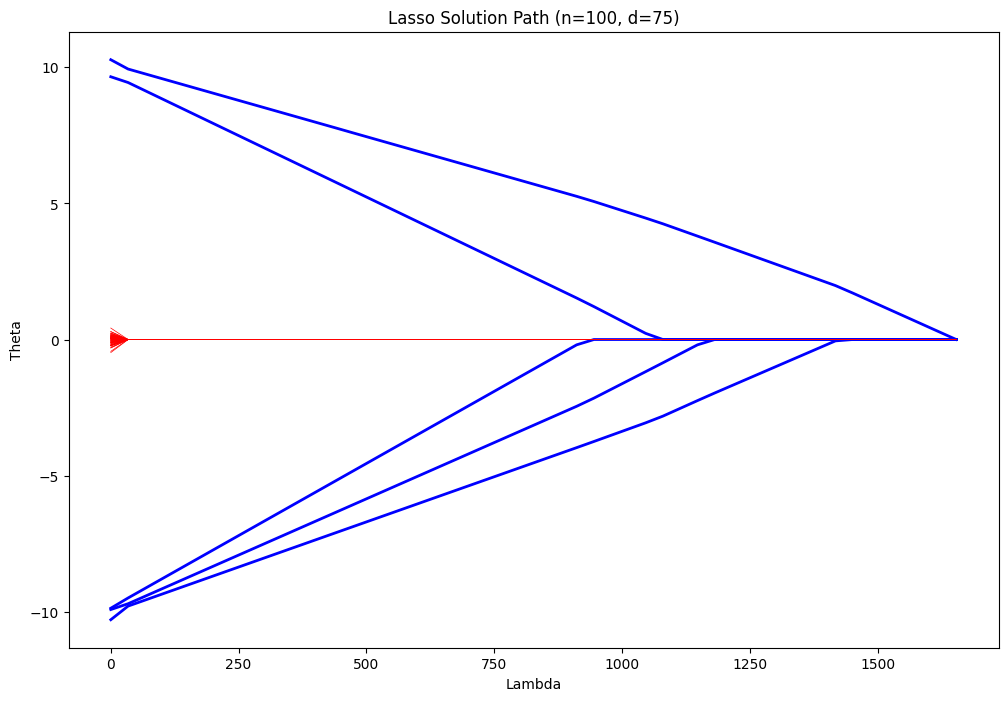

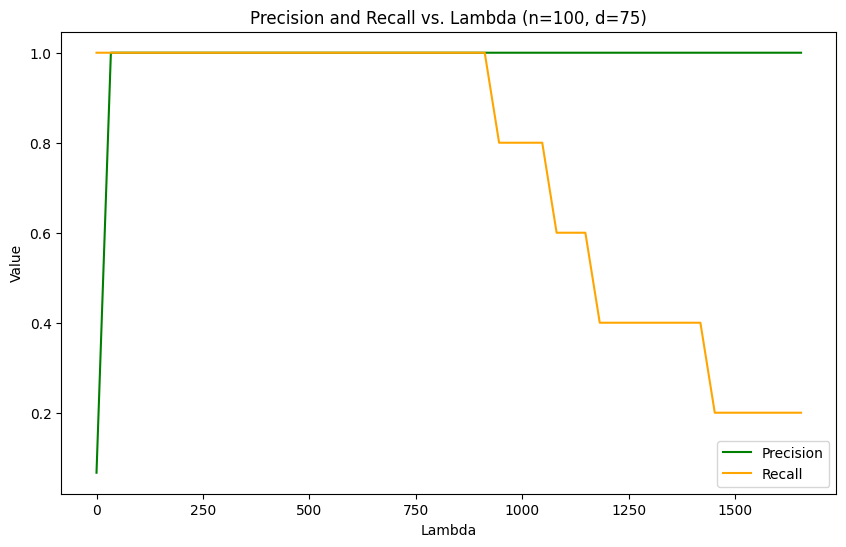

First Lambda=911.4029 gives good precision and recall
Last Lambda=33.7557 gives good precision and recall


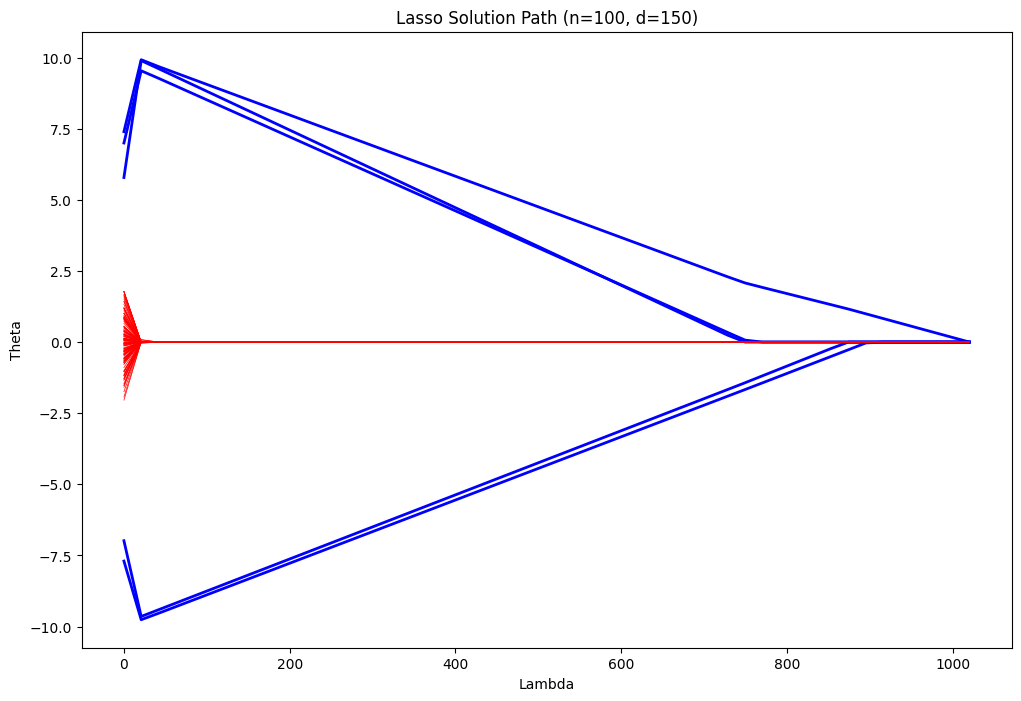

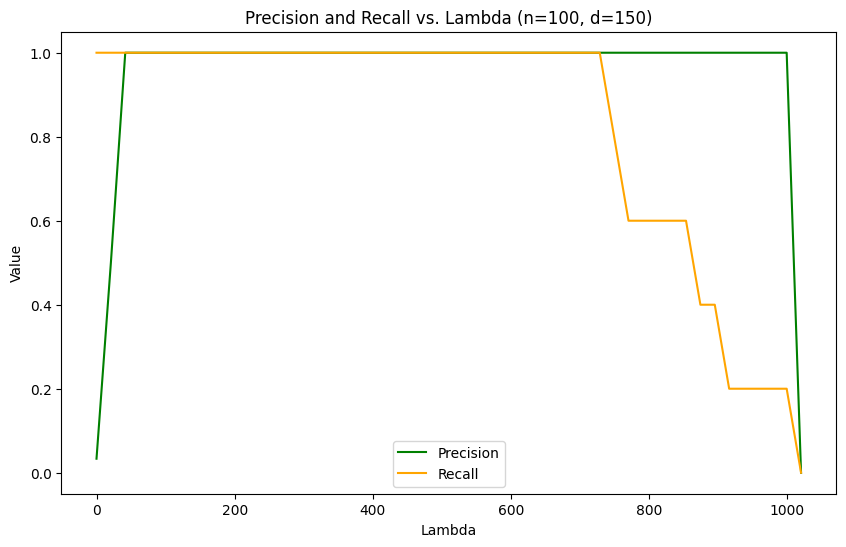

First Lambda=728.7076 gives good precision and recall
Last Lambda=41.6404 gives good precision and recall


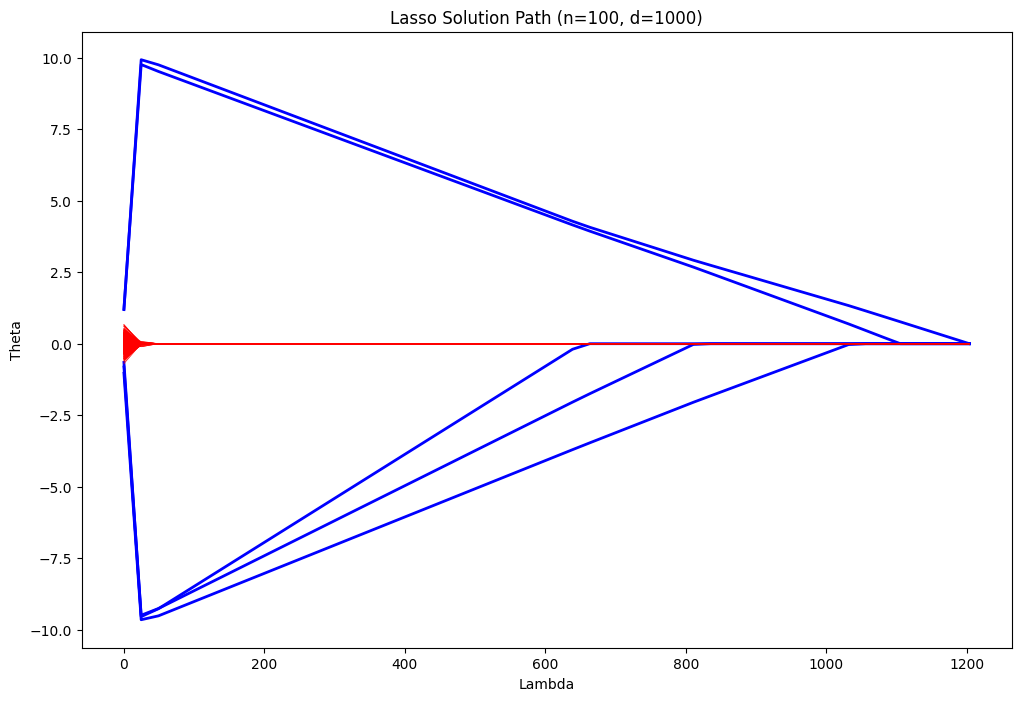

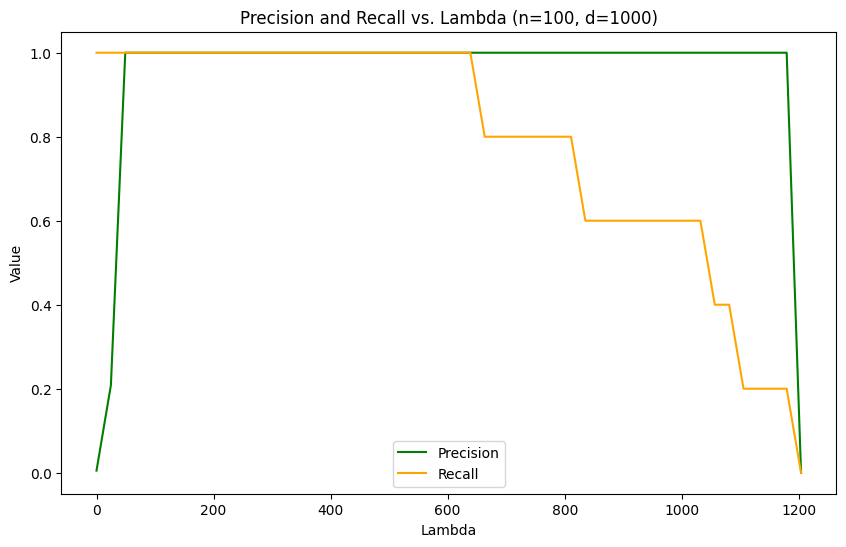

First Lambda=638.7761 gives good precision and recall
Last Lambda=49.1366 gives good precision and recall


In [14]:
# Sub-Problem 4
# TODO: try another 5 different choices of (n,d)
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
n_d_pairs = [
    (50, 75),
    (50, 150),
    (50, 1000),
    (100, 75),
    (100, 150),
    (100, 1000)
]

for n,d in n_d_pairs:

  X, y, w_true, w0_true = DataGenerator(n=n, d=d, k=5, sigma=1.0)

  W, W0, Lmda = LassoPath(X, y)

  # Evaluate the Lasso solution path
  RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

  # Plot the Lasso solution paths
  plt.figure(figsize=(12, 8))
  # Indices of the true features
  true_indices = set(np.nonzero(w_true)[0])

  for i in range(W.shape[0]):
      if i in true_indices:
          plt.plot(Lmda, W[i, :], color='blue', linewidth=2)
      else:
          plt.plot(Lmda, W[i, :], color='red', linewidth=0.5)

  plt.xlabel('Lambda')
  plt.ylabel('Theta')
  plt.title(f'Lasso Solution Path (n={n}, d={d})')
  plt.show()

  # Plot precision and recall vs. lambda
  plt.figure(figsize=(10, 6))
  plt.plot(Lmda, Precision, label='Precision', color='green')
  plt.plot(Lmda, Recall, label='Recall', color='orange')
  plt.xlabel('Lambda')
  plt.ylabel('Value')
  plt.title(f'Precision and Recall vs. Lambda (n={n}, d={d})')
  plt.legend()
  plt.show()

  # Initialize a list to store indices where precision and recall are above 0.9
  good_lambda_indices = []

  # Loop through all lambda values
  for idx, (prec, rec) in enumerate(zip(Precision, Recall)):
      if prec >= 0.9 and rec >= 0.9:
          good_lambda_indices.append(idx)

  # Check if we found any lambdas that satisfy the condition
  if good_lambda_indices:
      # Get the first and last indices
      first_good_idx = good_lambda_indices[0]
      last_good_idx = good_lambda_indices[-1]

      # Get the corresponding lambda values
      first_good_lambda = Lmda[first_good_idx]
      last_good_lambda = Lmda[last_good_idx]

      print(f"First Lambda={first_good_lambda:.4f} gives good precision and recall")
      print(f"Last Lambda={last_good_lambda:.4f} gives good precision and recall")
  else:
      print("Could not find any lambda that gives both good precision and recall")


In [ ]:
# Sub-Problem 5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int32)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [ ]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots

# Adjusted lasso function for sparse matrices
def lasso_new(X, y, lmda=10.0, epsilon=1.0e-2, max_iter=100, draw_curve=False):
    n, d = X.shape

    # Initialize w and w0 using Initialw function
    w, w0 = Initialw(X, y)

    # Keep track of objective function values
    obj_values = []

    # Previous w for convergence check
    w_prev = np.copy(w)

    # Define the soft-thresholding function
    def soft_thresholding(a, b):
        return np.sign(a) * np.maximum(np.abs(a) - b, 0.0)

    # Initialize residual
    r = y - X.dot(w) - w0

    for iteration in range(max_iter):
        for j in range(d):
            # Extract column j of X
            X_j = X.getcol(j)  # Get column j as a sparse column vector

            # Compute z_j
            z_j = X_j.T.dot(X_j).data[0]  # Scalar value

            if z_j == 0:
                continue  # Skip if z_j is zero

            # Compute p_j
            p_j = X_j.T.dot(r)[0] + z_j * w[j]  # Scalar value

            # Update w_j
            w_j_old = w[j]
            w_j_new = soft_thresholding(p_j / z_j, lmda / z_j)

            w[j] = w_j_new

            # Update residual
            delta_w_j = w_j_new - w_j_old
            if delta_w_j != 0:
                # Efficiently update r only at non-zero positions of X_j
                r -= X_j.multiply(delta_w_j).toarray().ravel()

        # Update w0
        w0 = np.mean(y - X.dot(w))

        # Compute objective function value
        residual = y - X.dot(w) - w0
        obj = 0.5 * np.sum(residual ** 2) + lmda * np.sum(np.abs(w))
        obj_values.append(obj)

        # Check convergence
        max_w_change = np.max(np.abs(w - w_prev))
        if max_w_change <= epsilon:
            print(f"Converged at iteration {iteration+1}")
            break

        w_prev = np.copy(w)

    if draw_curve:
        plt.plot(obj_values)
        plt.xlabel('Iteration')
        plt.ylabel('Objective Function Value')
        plt.title('Objective Function vs. Iteration')
        plt.show()

    return (w, w0)

def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    n, d = X_train.shape

    # Ensure X_train and X_valid are in CSC format for efficient column slicing
    # if not sparse.isspmatrix_csc(X_train):
    #     X_train = X_train.tocsc()
    # if not sparse.isspmatrix_csc(X_valid):
    #     X_valid = X_valid.tocsc()

    # Compute lambda_max = max_j |X_j^T y_train|
    y_mean = np.mean(y_train)
    y_centered = y_train - y_mean
    Xy = X_train.T.dot(y_centered)
    lambda_max = np.max(np.abs(Xy))

    # Generate lambda values from lambda_max to a small fraction of lambda_max
    Lmda = np.linspace(lambda_max, 0.001 * lambda_max, 20)

    # Initialize variables to store the best model
    best_rmse = float('inf')
    best_w = None
    best_w0 = None
    best_lambda = None

    # Lists to store RMSEs for plotting
    RMSE_train = []
    RMSE_valid = []

    # Lists to store weights and intercepts for plotting solution paths
    W = []
    W0 = []

    for lmda in Lmda:
        # Run lasso on training set
        w_lasso, w0_lasso = lasso_new(X_train, y_train, lmda=lmda, epsilon=1.0e-2, max_iter=100, draw_curve=False)

        # Store weights and intercepts
        W.append(w_lasso)
        W0.append(w0_lasso)

        # Compute RMSE on validation set
        y_valid_pred = X_valid.dot(w_lasso) + w0_lasso
        rmse_valid = np.sqrt(np.mean((y_valid - y_valid_pred) ** 2))

        # Compute RMSE on training set
        y_train_pred = X_train.dot(w_lasso) + w0_lasso
        rmse_train = np.sqrt(np.mean((y_train - y_train_pred) ** 2))

        RMSE_valid.append(rmse_valid)
        RMSE_train.append(rmse_train)

        # Update best model if current rmse is better
        if rmse_valid < best_rmse:
            best_rmse = rmse_valid
            best_w = w_lasso
            best_w0 = w0_lasso
            best_lambda = lmda

    # Convert W and W0 to numpy arrays
    W = np.array(W).T  # Now W is d x len(Lmda)
    W0 = np.array(W0)

    print(f"Best lambda: {best_lambda}")
    print(f"Best validation RMSE: {best_rmse}")

    return (best_w, best_w0, best_lambda, W, W0, Lmda, RMSE_train, RMSE_valid)

In [ ]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
import numpy as np
from scipy.sparse.linalg import lsqr
from scipy import io

from google.colab import drive
drive.mount('/content/gdrive/')

X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('/content/gdrive/MyDrive/ML/hw3/data/star_data.mtx', '/content/gdrive/MyDrive/ML/hw3/data/star_labels.txt', '/content/gdrive/MyDrive/ML/hw3/data/star_features.txt', 30000, 5000)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

best_w, best_w0, best_lambda, W, W0, Lmda, RMSE_train, RMSE_valid = Validation(X_train, y_train, X_valid, y_valid)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
(30000, 2500) (30000,) (5000, 2500) (5000,) (10000, 2500) (10000,)
Converged at iteration 4
Converged at iteration 5
Converged at iteration 4
Converged at iteration 7
Converged at iteration 8
Converged at iteration 8
Converged at iteration 9
Converged at iteration 10
Converged at iteration 17
Converged at iteration 24
Converged at iteration 24
Converged at iteration 24
Converged at iteration 24
Converged at iteration 25
Converged at iteration 27
Converged at iteration 28
Converged at iteration 40
Converged at iteration 60
Best lambda: 2.1205611887312585
Best validation RMSE: 0.9939313866504504


Test RMSE: 1.045032501984395
Lasso selected features:
great: 19.26229151152147
not: -17.556867608439614
best: 17.23722918368723
amazing: 14.432943397906202
rude: -12.486928431306797
the worst: -12.09324579291976
love: 12.013622837990269
delicious: 11.908992902338277
awesome: 11.182766984153101
horrible: -10.759082597561214


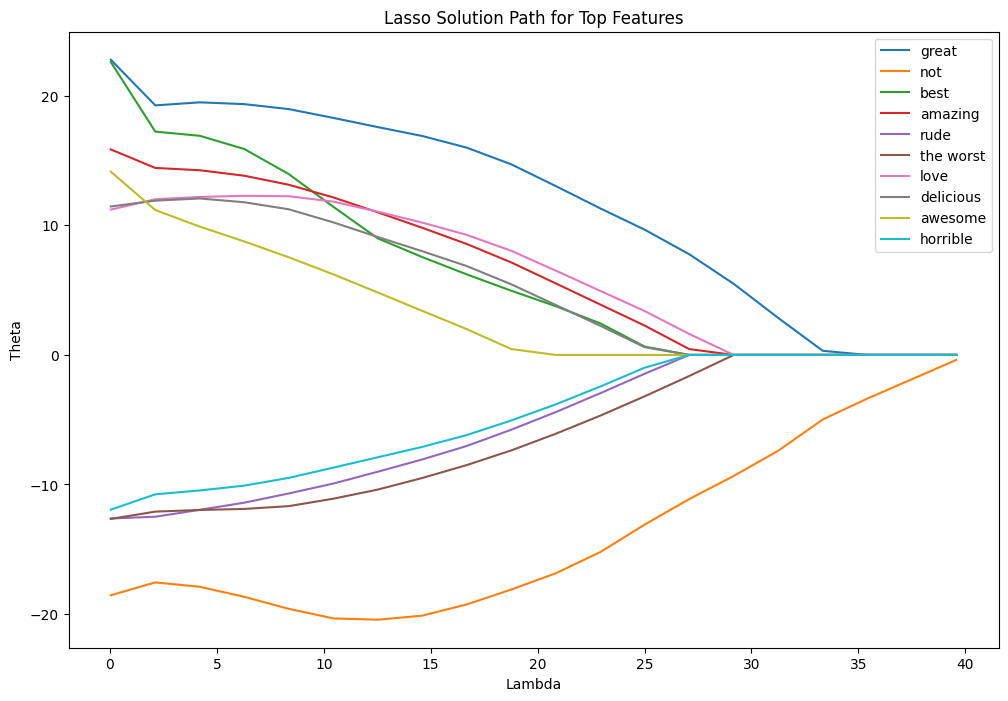

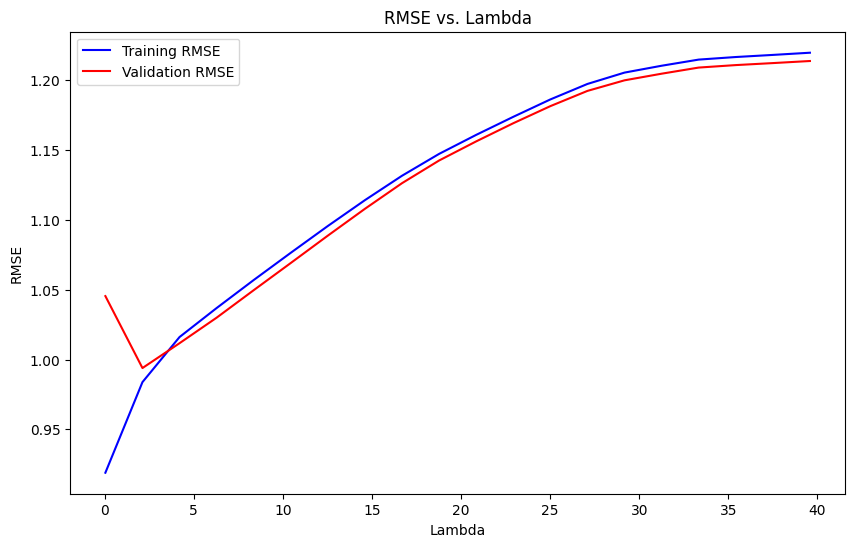

In [ ]:
# Compute RMSE on test set
# print(X_test.shape, best_w.shape, best_w0.shape)
y_test_pred = X_test @ best_w + best_w0
rmse_test = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
print(f"Test RMSE: {rmse_test}")

# Adjust w_lasso and fName if necessary
# if W.shape[0] < len(w_lasso):
#     w_lasso_sub = w_lasso[:W.shape[0]]
#     fName_sub = fName[:W.shape[0]]
# else:
#     w_lasso_sub = w_lasso
#     fName_sub = fName

# Compute idx using w_lasso_sub
# idx = (-np.abs(w_lasso_sub)).argsort()[0:10]

# Print the top-10 features you found by lasso
print('Lasso selected features:')
idx = (-np.abs(best_w)).argsort()[0:10]
for i in idx:
    print(f"{fName[i]}: {best_w[i]}")

# Plot the Lasso solution paths for the top-10 features
plt.figure(figsize=(12, 8))

# Plot θi vs λ for each θi in the top-10 features
for i in idx:
    plt.plot(Lmda, W[i, :], label=fName[i])

plt.xlabel('Lambda')
plt.ylabel('Theta')
plt.title('Lasso Solution Path for Top Features')
plt.legend()
# plt.gca().invert_xaxis()  # Reverse the x-axis to show decreasing lambda
plt.show()

# Plot RMSE vs lambda
plt.figure(figsize=(10, 6))
plt.plot(Lmda, RMSE_train, label='Training RMSE', color='blue')
plt.plot(Lmda, RMSE_valid, label='Validation RMSE', color='red')
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('RMSE vs. Lambda')
plt.legend()
# plt.gca().invert_xaxis()  # Reverse the x-axis to show decreasing lambda
plt.show()
